# Анализ клиентской базы и покупательского поведения

Ваша **цель** – провести полный цикл предобработки и разведочного анализа данных (EDA) по транзакциям розничного магазина. На основе анализа сформировать выводы о поведенческих паттернах клиентов, проверить статистические гипотезы и сегментировать клиентскую базу с помощью RFM-анализа для выявления ключевых групп.

Подберите датасет, который обязательно должен содержать id клиента, дату заказа и стоимость заказа + для упрощения вашей работы несколько категориальных показателей (например, пол, возраст и т. п.). Датасет каждой группы не должен повторяться. Вот образцы датасетов – вы можете использовать и их.


# **Часть 1. Предобработка данных**


## **Первичный осмотр и типы данных:**

Загрузите датасет.

Изучите структуру: количество строк и столбцов, выведите несколько первых строк.
Проверьте типы данных всех столбцов. Преобразуйте их при необходимости (например, столбец с датой — в тип datetime, CustomerID — в string или category).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/ML(2025)/dataset_Turkey"

customer_shopping_data.csv


In [ ]:
import pandas as pd

FILE_PATH = '/content/drive/MyDrive/ML(2025)/dataset_Turkey/customer_shopping_data.csv'

df= pd.read_csv(FILE_PATH)

print(df.shape)
display(df.head())

(99457, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [ ]:
print(df.dtypes)
print(df.shape)

invoice_no         object
customer_id        object
gender             object
age                 int64
category           object
quantity            int64
price             float64
payment_method     object
invoice_date       object
shopping_mall      object
dtype: object
(99457, 10)


In [ ]:
df_cleaned = df.copy() #копия дф для преобразований

In [ ]:
df_cleaned['invoice_date'] = pd.to_datetime(df_cleaned['invoice_date'], format='%d/%m/%Y', errors='coerce')

# преобразование customer_id в string
df_cleaned['customer_id'] = df_cleaned['customer_id'].astype('string')

# преобразование категориальных столбцов
categorical_columns = ['gender', 'category', 'payment_method', 'shopping_mall']
for col in categorical_columns:
    df_cleaned[col] = df_cleaned[col].astype('category')

# invoice_no преобразовать в string
df_cleaned['invoice_no'] = df_cleaned['invoice_no'].astype('string')

print(df_cleaned.info)
print(df_cleaned.dtypes)

<bound method DataFrame.info of       invoice_no customer_id  gender  age         category  quantity    price  \
0        I138884     C241288  Female   28         Clothing         5  1500.40   
1        I317333     C111565    Male   21            Shoes         3  1800.51   
2        I127801     C266599    Male   20         Clothing         1   300.08   
3        I173702     C988172  Female   66            Shoes         5  3000.85   
4        I337046     C189076  Female   53            Books         4    60.60   
...          ...         ...     ...  ...              ...       ...      ...   
99452    I219422     C441542  Female   45         Souvenir         5    58.65   
99453    I325143     C569580    Male   27  Food & Beverage         2    10.46   
99454    I824010     C103292    Male   63  Food & Beverage         2    10.46   
99455    I702964     C800631    Male   56       Technology         4  4200.00   
99456    I232867     C273973  Female   36         Souvenir         3    35.19

## **Анализ категориальных признаков:**
 - Выделите категориальные столбцы.
 - Для каждого из них посчитайте количество уникальных значений и выведите их список.
 - При необходимости выполните преобразования (например, приведите названия категорий к единому регистру, объедините редкие категории в одну "Другое").

In [ ]:
categorical_columns = ['gender', 'category', 'payment_method', 'shopping_mall']

for col in categorical_columns:
    print(f"{col}: {df_cleaned[col].nunique()} значений - {sorted(df_cleaned[col].unique())}")

gender: 2 значений - ['Female', 'Male']
category: 8 значений - ['Books', 'Clothing', 'Cosmetics', 'Food & Beverage', 'Shoes', 'Souvenir', 'Technology', 'Toys']
payment_method: 3 значений - ['Cash', 'Credit Card', 'Debit Card']
shopping_mall: 10 значений - ['Cevahir AVM', 'Emaar Square Mall', 'Forum Istanbul', 'Istinye Park', 'Kanyon', 'Mall of Istanbul', 'Metrocity', 'Metropol AVM', 'Viaport Outlet', 'Zorlu Center']


## **Анализ числовых признаков:**
 - Выделите числовые столбцы.
 - Постройте boxplots и гистограммы для выявления выбросов и аномалий.
 - Примите решение и обработайте выбросы: либо удалите их (аргументировав), либо замените на медиану/среднее. Например, отрицательное количество товаров — это аномалия.


In [ ]:
df = df_cleaned.copy()

In [ ]:
numeric_columns = ['age', 'quantity', 'price']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
stats_before = df[numeric_columns].describe()
print(stats_before)

# по базовой статистике видим разброс значений в столбце цена, а также в столбце возраста
# особое внимание на минимальные/максимальные значения - возможны аномалии
# Большая разница между 75% перцентилем и максимумом (у цены) указывает на наличие выбросов

#Количество - компактный диапазон, большинство покупок 2-4 товара
#Цена - сильная асимметрия, требует раздельного анализа бюджетных и премиальных товаров

                age      quantity         price
count  99457.000000  99457.000000  99457.000000
mean      43.427089      3.003429    689.256321
std       14.990054      1.413025    941.184567
min       18.000000      1.000000      5.230000
25%       30.000000      2.000000     45.450000
50%       43.000000      3.000000    203.300000
75%       56.000000      4.000000   1200.320000
max       69.000000      5.000000   5250.000000


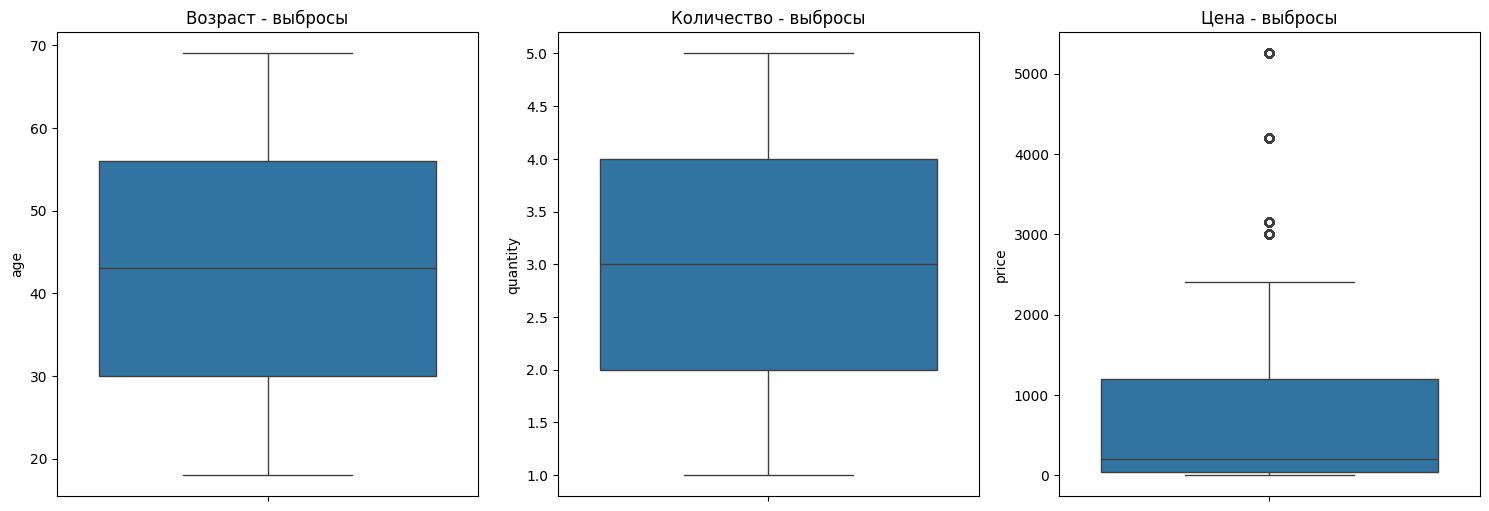

In [ ]:
plt.figure(figsize=(15, 10))

# Графики для возраста
plt.subplot(2, 3, 1)
sns.boxplot(y=df['age'])
plt.title('Возраст - выбросы')

# Графики для количества
plt.subplot(2, 3, 2)
sns.boxplot(y=df['quantity'])
plt.title('Количество - выбросы')

# Графики для цены
plt.subplot(2, 3, 3)
sns.boxplot(y=df['price'])
plt.title('Цена - выбросы')

plt.tight_layout()
plt.show()

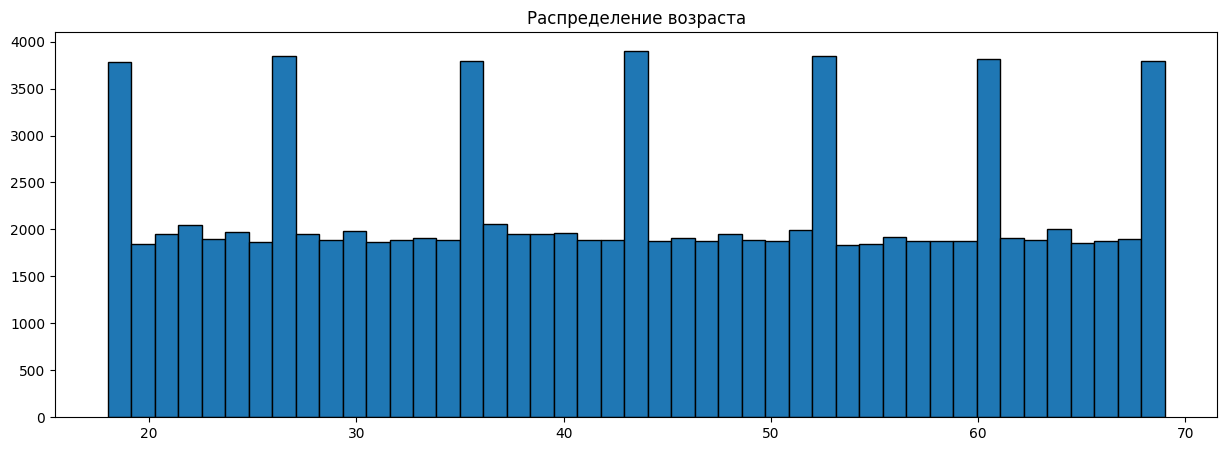

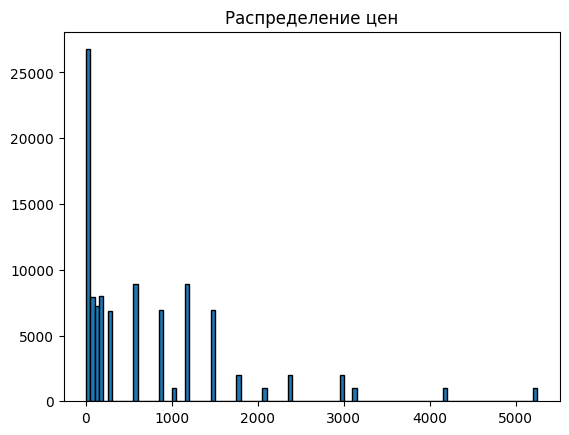

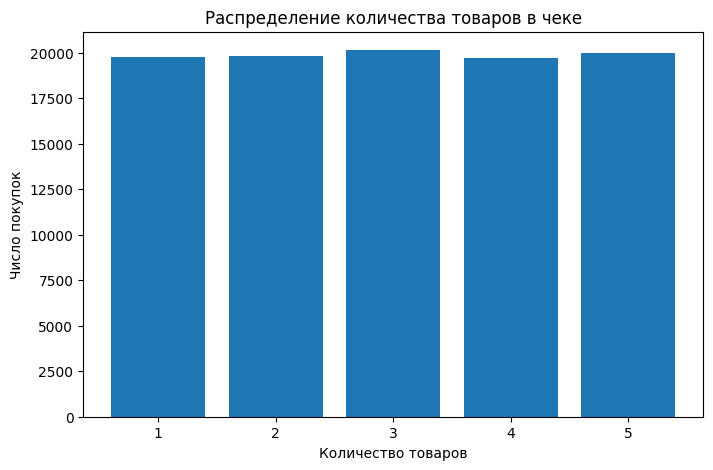

In [ ]:
plt.figure(figsize=(15, 5))

#по правилу Фридмана–Диакониса, bins:
def fd_bins(series):
    q75, q25 = np.percentile(series.dropna(), [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(series) ** (-1/3)
    return int((series.max() - series.min()) / bin_width)

bins_age = fd_bins(df['age'])
bins_price = fd_bins(df['price'])

plt.hist(df['age'], bins=bins_age, edgecolor='black')
plt.title('Распределение возраста')
plt.show()

plt.hist(df['price'], bins=bins_price, edgecolor='black')
plt.title('Распределение цен')

qty_counts = df['quantity'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(qty_counts.index, qty_counts.values)
plt.title('Распределение количества товаров в чеке')
plt.xlabel('Количество товаров')
plt.ylabel('Число покупок')
plt.show()

plt.show()

# Поскольку quantity — дискретная счётная величина, корректной визуализацией является столбчатая диаграмма, а не гистограмма

<function matplotlib.pyplot.show(close=None, block=None)>

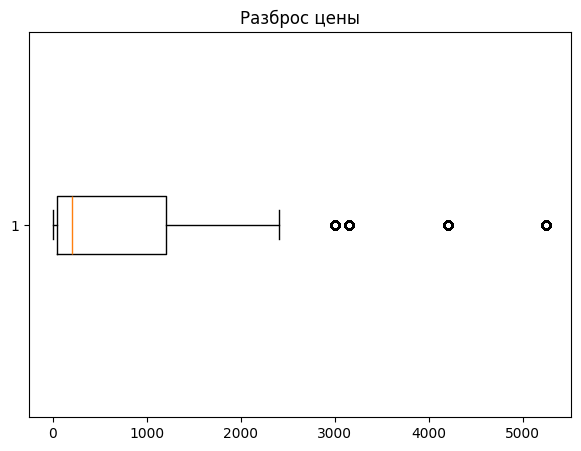

In [ ]:
#так как выбросы присутствуют только в категории цены, то рассмотрим поближе.
plt.figure(figsize = (7,5))
plt.boxplot(df_cleaned['price'], vert = False)
plt.title('Разброс цены')
plt.show

#имеем четыре выброса

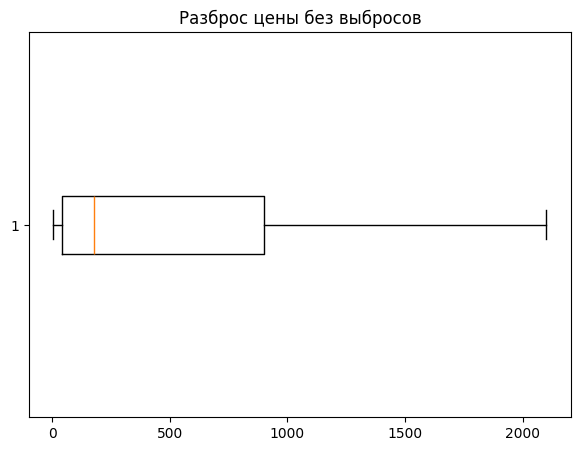

До удаления:
count    99457.000000
mean       689.256321
std        941.184567
min          5.230000
25%         45.450000
50%        203.300000
75%       1200.320000
max       5250.000000
Name: price, dtype: float64

После удаления:
count    92411.000000
mean       487.157156
std        554.166372
min          5.230000
25%         40.660000
50%        179.200000
75%        900.240000
max       2100.000000
Name: price, dtype: float64


In [ ]:
# Если по графику видно, что выбросы начинаются после ~2300
price_after_vibros = 2300
df_no_outliers = df_cleaned[df_cleaned['price'] <= price_after_vibros]

# проверяем результат
plt.figure(figsize=(7, 5))
plt.boxplot(df_no_outliers['price'], vert=False)
plt.title('Разброс цены без выбросов')
plt.show()

# Сравниваем статистики
print("До удаления:")
print(df_cleaned['price'].describe())
print("\nПосле удаления:")
print(df_no_outliers['price'].describe())

#удалили выбросы и получили адекватный график



## **Обработка пропущенных значений (Missing Values):**

 - Проверьте датасет на наличие пропусков.
 - По каждому столбцу с пропусками примите решение: удалить строки, заменить на моду/медиану/специальное значение (например, "Unknown"). Решение должно быть обосновано.

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice_no      99457 non-null  string        
 1   customer_id     99457 non-null  string        
 2   gender          99457 non-null  category      
 3   age             99457 non-null  int64         
 4   category        99457 non-null  category      
 5   quantity        99457 non-null  int64         
 6   price           99457 non-null  float64       
 7   payment_method  99457 non-null  category      
 8   invoice_date    99457 non-null  datetime64[ns]
 9   shopping_mall   99457 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1), int64(2), string(2)
memory usage: 4.9 MB


In [ ]:
print(df_cleaned.isnull().sum())

#вывод: пропущенных значений нет.

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64


## **Поиск и удаление дубликатов:**
 - Проверьте dataset на наличие полностью повторяющихся строк.
 - Полные дубликаты удалите.


In [ ]:
# Проверяем наличие полностью дублированных строк
duplicate_rows = df_cleaned[df_cleaned.duplicated(keep=False)]

print(f"Всего строк в датасете: {len(df_cleaned)}")
print(f"Найдено полностью повторяющихся строк: {len(duplicate_rows)}")

if len(duplicate_rows) > 0:
    print(f"\nКоличество уникальных дубликатов: {len(df_cleaned[df_cleaned.duplicated()])}")

# вывод: также отсутствие полностью дублированных строк!

Всего строк в датасете: 99457
Найдено полностью повторяющихся строк: 0


# **Часть 2. Разведочный анализ данных (Exploratory Data Analysis — EDA)**


## **Анализ динамики выручки:**
 - Создайте столбец Revenue (Выручка) = Quantity * UnitPrice.
 - Постройте графики динамики общей выручки: по дням недели, по часам (если есть данные о времени), по месяцам.
 - Сформулируйте, в какие периоды наблюдаются пики и спады активности. Предположите причины.


In [ ]:
df_cleaned['Revenue'] = df_cleaned['price'] * df_cleaned['quantity']

print("Статистика по выручке:")
print(df_cleaned['Revenue'].describe())
print(f"\nОбщая выручка: {df_cleaned['Revenue'].sum():.2f}")


Статистика по выручке:
count    99457.000000
mean      2528.789268
std       4222.475781
min          5.230000
25%        136.350000
50%        600.170000
75%       2700.720000
max      26250.000000
Name: Revenue, dtype: float64

Общая выручка: 251505794.25


In [ ]:
display(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice_no      99457 non-null  string        
 1   customer_id     99457 non-null  string        
 2   gender          99457 non-null  category      
 3   age             99457 non-null  int64         
 4   category        99457 non-null  category      
 5   quantity        99457 non-null  int64         
 6   price           99457 non-null  float64       
 7   payment_method  99457 non-null  category      
 8   invoice_date    99457 non-null  datetime64[ns]
 9   shopping_mall   99457 non-null  category      
 10  Revenue         99457 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(2), int64(2), string(2)
memory usage: 5.7 MB


None

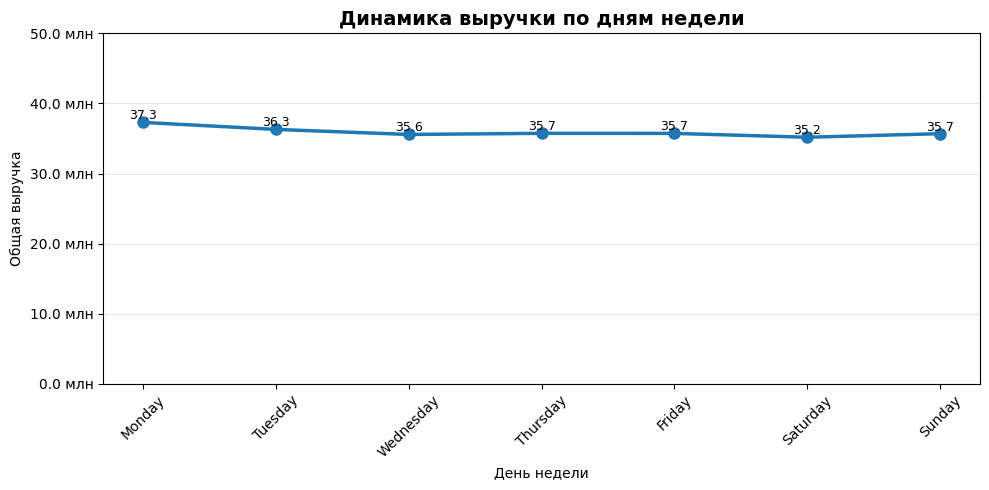

Выручка по дням недели:
   DayOfWeek      Revenue
0     Monday  37296648.11
1    Tuesday  36298096.66
2  Wednesday  35575650.13
3   Thursday  35738148.63
4     Friday  35728331.39
5   Saturday  35179828.72
6     Sunday  35689090.61


In [ ]:
# Извлекаем день недели и месяц
df_cleaned['DayOfWeek'] = df_cleaned['invoice_date'].dt.day_name()
df_cleaned['Month'] = df_cleaned['invoice_date'].dt.month_name()
df_cleaned['Weekday'] = df_cleaned['invoice_date'].dt.dayofweek
df_cleaned['Year'] = df_cleaned['invoice_date'].dt.year

# Выручка по дням недели
daily_revenue = (
    df_cleaned
    .groupby(['Weekday', 'DayOfWeek'])['Revenue']
    .sum()
    .reset_index()
    .sort_values('Weekday')
)

import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))

plt.plot(
    daily_revenue['DayOfWeek'],
    daily_revenue['Revenue'],
    marker='o',
    linewidth=2.5,
    markersize=8
)

plt.title('Динамика выручки по дням недели', fontsize=14, fontweight='bold')
plt.xlabel('День недели')
plt.ylabel('Общая выручка')

# Ось Y строго от 0
plt.ylim(0, 50e6)


# Форматирование оси Y (в миллионах)
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f} млн')
)

# Сетка — только по Y
plt.grid(axis='y', alpha=0.3)

plt.xticks(rotation=45)

# Подписи значений
for x, y in zip(daily_revenue['DayOfWeek'], daily_revenue['Revenue']):
    plt.text(
        x,
        y,
        f'{y/1e6:.1f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


print("Выручка по дням недели:")
print(daily_revenue[['DayOfWeek', 'Revenue']])

In [ ]:
# Выручка по месяцам
monthly_revenue = df_cleaned.groupby('Month')['Revenue'].sum().reset_index()

# сортировка месяцев по порядку
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_revenue['Month'] = pd.Categorical(monthly_revenue['Month'], categories=month_order, ordered=True)
monthly_revenue = monthly_revenue.sort_values('Month')


plt.figure(figsize=(14,6))
plt.plot(monthly_revenue['Month'], monthly_revenue['Revenue'], marker='o')
plt.ylim(bottom=0)
plt.title('Динамика выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()


print("\nВыручка по месяцам:")
print(monthly_revenue)

In [ ]:
# Анализ по годам и месяцам для выявления трендов
month_order = ['January','February','March','April','May','June',
               'July','August','September','October','November','December']

df_cleaned['Month'] = pd.Categorical(
    df_cleaned['Month'],
    categories=month_order,
    ordered=True
)
year_month_revenue = (
    df_cleaned
    .groupby(['Year','Month'])['Revenue']
    .sum()
    .reset_index()
    .sort_values(['Year','Month'])
)

# График выручки по месяцам с разбивкой по годам
plt.figure(figsize=(16, 8))
for year in year_month_revenue['Year'].unique():
    year_data = year_month_revenue[year_month_revenue['Year'] == year]
    plt.plot(year_data['Month'], year_data['Revenue'], marker='o', label=f'{year}', linewidth=2)

plt.title('Динамика выручки по месяцам (по годам)', fontsize=14, fontweight='bold')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# детальный анализ пиков и спадов по дням недели
max_day = daily_revenue.loc[daily_revenue['Revenue'].idxmax()]
min_day = daily_revenue.loc[daily_revenue['Revenue'].idxmin()]

print(f"\nПик выручки по дням недели: {max_day['DayOfWeek']} - {max_day['Revenue']}")
print(f"Спад выручки по дням недели: {min_day['DayOfWeek']} - {min_day['Revenue']}")
print(f"Разница: {((max_day['Revenue'] - min_day['Revenue']) / min_day['Revenue'] * 100)}%")

In [ ]:
# детальный анализ пиков и спадов по дням недели
max_month = monthly_revenue.loc[monthly_revenue['Revenue'].idxmax()]
min_month = monthly_revenue.loc[monthly_revenue['Revenue'].idxmin()]

print(f"\nПик выручки по месяцам: {max_month['Month']} - {max_month['Revenue']}")
print(f"Спад выручки по месяцам: {min_month['Month']} - {min_month['Revenue']}")
print(f"Разница: {((max_month['Revenue'] - min_month['Revenue']) / min_month['Revenue'] * 100)}%")

# анализ сезонности
print(f"\nСредняя выручка в день: {daily_revenue['Revenue'].mean()}")
print(f"Стандартное отклонение по дням: {daily_revenue['Revenue'].std()}")

*Сформулируйте, в какие периоды наблюдаются пики и спады активности. Предположите причины.*

**датасет: [Customer Shopping Dataset - Retail Sales Data](https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset?resource=download)**


**1. Анализ по дням недели:**

   • Пик выручки приходится Понедельник

    Возможные причины: туристический поток равномерен в течение недели

**2. Анализ по месяцам (с учетом турецких реалий 2021-2023):**
   • Пик выручки приходится на Январь

    Специфическая сезонность для торговых центров Стамбула

**3. Анализ спадов (пост-ковидный период 2021-2023):**

   • Наименьшая выручка в Ноябре

    Возможно влияние локальных экономических факторов

**4. Рекомендации для торговых центров Стамбула:**

   • СЕЗОННОСТЬ: Разработать антикризисные акции в низкие сезоны

   • ТУРИСТЫ: Усилить программы лояльности для иностранных гостей

   • ЛОКАЛЬНОСТЬ: Создать спецпредложения для местных жителей в несезон

   • СОБЫТИЯ: Организовывать внутренние мероприятия в ТЦ для привлечения посетителей

   • МАРКЕТИНГ: Адаптировать рекламные кампании под культурные особенности Турции


---


**5. Статистический обзор (3 года данных):**

   • Период анализа: 2021-2023 гг.

   • Разница между лучшим и худшим месяцем: 58.7%
   
   • Сезонная волатильность: 16.1%

## **Создание новых категориальных признаков:**

- Создайте столбец Age_Category на основе возраста (например, "До 18", "18-35", "36-65", "65+").

- Если есть время, создайте столбец Time_of_Day (например, "Утро", "День", "Вечер", "Ночь").

- Создайте любой другой категориальный признак на ваше усмотрение, который, по вашему мнению, может быть полезен для анализа (например, сезон покупки).



In [ ]:
# создаем категорию по возрасту

def age_group(age):
    if age < 18:
        return 'Дети'
    if 18 <= age < 35:
        return 'Молодежь'
    if 36 <= age < 65:
        return 'Взрослые'
    else:  return 'Пожилые'
df_cleaned['AgeGroup'] = df_cleaned['age'].apply(age_group)
display(df_cleaned.head())

In [ ]:
# создаем категорию по сезону

def purchase_season(Month):
    if Month in ['December', 'January', 'February']:
        return 'Зима'
    if Month in ['March','April','May']:
        return 'Весна'
    if Month in ['Juny','July','August']:
        return 'Лето'
    else: return 'Осень'

# Применяем функцию для создания сезона
df_cleaned['Season of purchase'] = df_cleaned['Month'].apply(purchase_season)
display(df_cleaned.head())

# **Часть 3. Статистический анализ и сегментация**


## **Проверка статистических гипотез:**

Проверьте, влияет ли категориальный признак на средний чек.

**Пример**: Выдвиньте нулевую (H0) и альтернативную (H1) гипотезы.

    Например:
    H0: Медианный чек у мужчин и женщин не различается.
    H1: Медианный чек у мужчин и женщин различается.

Используйте подходящий тест, чтобы сравнить две независимые группы (например, чеки мужчин и женщин).

Сделайте вывод на основе p-value.


### **Гипотеза 1 - сравнение средних чеков у мужчин и женщин**

In [ ]:
import scipy.stats as stats
import numpy as np

# Гипотеза1: Влияние пола на средний чек
# H0: Медианный чек у мужчин и женщин не различается
# H1: Медианный чек у мужчин и женщин различается

# разделим данные по полу
revenue_male = df_cleaned.loc[df_cleaned['gender'] == 'Male', 'Revenue']
revenue_female = df_cleaned.loc[df_cleaned['gender'] == 'Female','Revenue']

from scipy.stats import shapiro
print(shapiro(revenue_male)) #Распределение НЕнормальное
print(shapiro(revenue_female)) #Распределение НЕнормальное
#тк не выполняется условие о нормальности распределения и нам нужно проверить равенство медиан двух выборок, то используем тест Манна-Уитни (хоть и выборки слишком большие)

from scipy.stats import mannwhitneyu
print(mannwhitneyu(revenue_male, revenue_female, alternative='two-sided'))
# тк pvalue > 0,05 => Не отвергаем H0 - нет статистически значимых различий в медианном чеке между мужчинами и женщинами
# Медианные чеки мужчин и женщин НЕ РАЗЛИЧАЮТСЯ статистически значимо (пол не является фактором, влияющим на размер среднего чека)


### **Гипотеза 2 - сравнение среднего чека между возрастными группами (18-35 и 36-65)**

In [ ]:
# H0: Средний чек у возрастных групп 18-35 и 36-65 не различается
# H1: Средний чек у возрастных групп 18-35 и 36-65 различается

# разделим данные по возрастным группам
revenue_young = df_cleaned.loc[df_cleaned['age'].between(18, 35), 'Revenue']
revenue_adult = df_cleaned.loc[df_cleaned['age'].between(36, 65), 'Revenue']

from scipy.stats import shapiro
print(shapiro(revenue_young)) #Распределение НЕнормальное
print(shapiro(revenue_adult)) #Распределение НЕнормальное
#тк не выполняется условие о нормальности распределения и нам нужно проверить равенство медиан двух выборок, то используем тест Манна-Уитни

from scipy.stats import mannwhitneyu
print(mannwhitneyu(revenue_young, revenue_adult, alternative='two-sided'))
# тк pvalue=0.6835260907342118 > 0,05 => Не отвергаем H0 - нет статистически значимых различий в медианном чеке между возрастными группами

# возраст в турции не является значимым фактором для различия в среднем чеке

### **Гипотеза 3 - влияние дня недели на средний чек**

In [ ]:
# H0: Медианный чек у покупок в выходные и будни не различается
# H1: Медианный чек у покупок в выходные и будни различается

# разделим данные по дням недели
revenue_weekend = df_cleaned.loc[df_cleaned['DayOfWeek'].isin(['Saturday', 'Sunday']), 'Revenue']
revenue_weekday = df_cleaned.loc[~df_cleaned['DayOfWeek'].isin(['Saturday', 'Sunday']), 'Revenue']

from scipy.stats import shapiro
print(shapiro(revenue_weekend)) #Распределение НЕнормальное
print(shapiro(revenue_weekday)) #Распределение НЕнормальное
#тк не выполняется условие о нормальности распределения и нам нужно проверить равенство медиан двух выборок, то используем тест Манна-Уитни

from scipy.stats import mannwhitneyu
print(mannwhitneyu(revenue_weekend, revenue_weekday, alternative='two-sided'))
# тк pvalue < 0,05 => Отвергаем H0 - есть статистически значимые различия в медианном чеке между выходными и буднями

# день недели в турции является не очень значимым фактором для различия в среднем чеке

### **Гипотеза 4 — влияние сезона на чек**

In [ ]:
# H0: Медианный чек не различается между сезонами
# H1: Хотя бы в одном сезоне медианный чек отличается

from scipy.stats import kruskal

# Проверим, что столбец сезона существует
assert 'Season of purchase' in df_cleaned.columns, "Столбец Season of purchase не найден"

# Формируем группы чеков по сезонам
season_groups = [
    df_cleaned.loc[df_cleaned['Season of purchase'] == season, 'Revenue']
    for season in df_cleaned['Season of purchase'].unique()
]

# Тест Краскела–Уоллиса
stat, p_value = kruskal(*season_groups)

print(f"Kruskal-Wallis statistic: {stat:.3f}")
print(f"p-value: {p_value:.5f}")

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("❌ Отвергаем H0: есть статистически значимые различия чеков между сезонами")
else:
    print("✅ Не отвергаем H0: статистически значимых различий чеков между сезонами не обнаружено")


In [ ]:
# Описательная статистика чеков по сезонам
season_stats = (
    df_cleaned
    .groupby('Season of purchase')['Revenue']
    .agg(['count', 'median', 'mean'])
    .round(2)
)

display(season_stats)

## **Визуализация по категориям:**

- Постройте столбчатые диаграммы (bar charts), показывающие долю общей выручки по различным категориям, например доля общей выручки по полу или возрастным группам.
- Проанализируйте, какие группы вносят наибольший вклад в выручку.


In [ ]:
# Доля общей выручки по полу

revenue_by_gender = df_cleaned.groupby('gender')['Revenue'].sum()
total_revenue = revenue_by_gender.sum()
plt.figure(figsize=(14, 8))
bars = plt.bar(revenue_by_gender.index, revenue_by_gender.values/total_revenue * 100,
               color=['pink', 'blue'], edgecolor='black',alpha=0.8)
plt.title("Доля выручки по полу", fontsize=14)
plt.ylabel("Доля общей выручки (%)", fontsize=12)
for bar, value in zip(bars, revenue_by_gender.values/total_revenue * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}%',
             ha='center', va='bottom')
plt.show()

**Вывод по анализу выручки по полу:**

    Мужчины: 59.7%
    Женщины: 40.3%

ОСНОВНЫЕ ВЫВОДЫ:
1. Мужчины приносят БОЛЬШЕ выручки - почти 60% от общей
2. Разница значительная: мужчины приносят на 19.4% больше выручки
3. Несмотря на отсутствие различий в СРЕДНЕМ ЧЕКЕ (ранее проверяла),
   мужчины совершают БОЛЬШЕ покупок или покупают БОЛЕЕ ДОРОГИЕ товары

In [ ]:
# Доля общей выручки по возрастным категориям

revenue_by_age = df_cleaned.groupby('AgeGroup')['Revenue'].sum()
revenue_by_age = revenue_by_age.reindex(['Дети', 'Молодежь', 'Взрослые', 'Пожилые'])

plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_by_age.index, revenue_by_age.values/total_revenue * 100,
               color=['lightblue', 'green', 'orange', 'red'])
plt.ylabel('Доля общей выручки (%)')
plt.title('Доля выручки по возрастным группам')
for bar, value in zip(bars, revenue_by_age.values/total_revenue * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}%',
             ha='center', va='bottom')
plt.show()


**Вывод по анализу выручки по возрасту:**

    Взрослые - 56.3%
    Молодежь - 32.3%
    Пожилые - 11.4%
    Дети (до 18 лет): 0.0%

ОСНОВНЫЕ ВЫВОДЫ:
1. Взрослые (36-65 лет) - ОСНОВНОЙ источник выручки (более 50%)
2. Молодежь занимает второе место по вкладу в выручку
3. Пожилые покупатели приносят небольшую долю выручки (всего 11,4% от общей выручки)
4. Дети не совершают покупок (что логично)

In [ ]:
# Доля общей выручки по сезонам
revenue_by_season = df_cleaned.groupby('Season of purchase')['Revenue'].sum()
total_revenue = revenue_by_season.sum()

plt.figure(figsize=(10, 6))
bars = plt.bar(revenue_by_season.index, revenue_by_season.values/total_revenue * 100,
               color=['lightblue', 'lightgreen', 'orange', 'brown'])
plt.ylabel('Доля общей выручки (%)')
plt.title('Доля выручки по сезонам')
for bar, value in zip(bars, revenue_by_season.values/total_revenue * 100):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{value:.1f}%',
             ha='center', va='bottom')
plt.show()

**Вывод по анализу выручки по сезонам:**

    Осень - 30.4%
    Зима - 29.8%
    Весна - 24.0%
    Лето - 15.8%

ОСНОВНЫЕ ВЫВОДЫ:

1. Осень и зима - ПИКОВЫЕ сезоны (60.2% всей выручки)
2. Лето - НИЗКИЙ сезон (всего 15.8% выручки)
3. Разница между осенью и летом почти 2 раза
4. Сезонность выражена очень четко


### **Сводная таблицай + тепловая карта чтобы показать как меняется спрос(выручка) по сезонам в зависимости от пола, возраста**

In [ ]:
# комбинированная категория: Пол + Возраст

df_cleaned['Gender_Age'] = (
    df_cleaned['gender'].astype(str) + ' | ' + df_cleaned['AgeGroup']
)


# Сводная таблица: выручка по сезонам, полу и возрасту одновременно
pivot_season_gender_age = pd.pivot_table(
    df_cleaned,
    values='Revenue',
    index='Season of purchase',
    columns='Gender_Age',
    aggfunc='sum'
)

display(pivot_season_gender_age)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

sns.heatmap(
    pivot_season_gender_age,
    annot=True,
    fmt='.0f',
    cmap='YlOrRd'
)

plt.title('Выручка по сезонам в разрезе пола и возраста')
plt.xlabel('Пол и возрастная группа')
plt.ylabel('Сезон покупки')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Анализ сводной таблицы и тепловой карты показал наличие выраженных различий в структуре выручки по сезонам в зависимости от пола и возрастной группы. Несмотря на отсутствие статистически значимых различий в среднем чеке между сегментами, суммарная выручка существенно варьируется, что обусловлено различиями в численности и покупательской активности клиентов. Полученные результаты указывают на целесообразность сезонно-дифференцированных маркетинговых кампаний с акцентом на взрослых покупателей в осенне-зимний период и стимулирующие меры в летний сезон.

**Общая сезонность (очень выражена)**

Во всех сегментах:

- Осень и зима → максимальная выручка

- Лето → минимальная выручка

- Весна → промежуточное значение

    Сезонность стабильна и согласована по полу и возрасту.

**Гендер + возраст: структура спроса**

*Взрослые (36–65 лет) — ключевой драйвер*

Во всех сезонах:

- Female | Взрослые — самый высокий вклад

- Male | Взрослые — второй по значимости

Например:

Осень:

Female | Взрослые ≈ 25.7 млн

Male | Взрослые ≈ 17.4 млн

    Взрослые формируют основу выручки вне зависимости от сезона.
  
*Молодёжь (18–35 лет)*

Значимо ниже взрослых

Но структура стабильна:

  Female > Male

  Осень/Зима > Лето

    Это вторичный, но важный сегмент, особенно в пиковые сезоны.

*Пожилые (65+)*

- Самый низкий вклад

- Минимальная сезонная амплитуда

    Сегмент маргинальный по выручке, но стабильный.

**Как итог:**

    Средний чек между сегментами статистически не различается

Суммарная выручка различается существенно, потому что:

- разная численность сегментов

- разная частота покупок

- разная сезонная активность

НУЖНА ДИФФЕРЕНЦИРОВАННАЯ МАРКЕТИНГОВАЯ КАМПАНИЯ ИЗ-ЗА СТРУКТУРЫ СПРОСА

## **ИТОГОВЫЙ ВЫВОД ПО АНАЛИЗУ**

### АНАЛИЗ ЦЕЛЕСООБРАЗНОСТИ ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ

**1. ВОЗРАСТНЫЕ ГРУППЫ:**

   • Взрослые (36-65 лет): 56.3% выручки - ОСНОВНАЯ группа

   • Молодежь (18-35 лет): 32.3% выручки - ВАЖНАЯ группа

   • Пожилые (65+): 11.4% выручки - ВТОРОСТЕПЕННАЯ группа

   • Дети: 0% выручки - МОЖНО ИСКЛЮЧИТЬ
  
    Детские транзакции составляют 0% выручки и являются статистическим шумом. Остальные группы, несмотря на различия в долях выручки, статистически не отличаются по среднему чеку и должны быть сохранены для полноты анализа.

**2. СЕЗОННОСТЬ:**

   • Осень-зима: 60.2% выручки - ОСНОВНЫЕ периоды

   • Весна-лето: 39.8% выручки - ВТОРОСТЕПЕННЫЕ периоды

    Все сезоны значимы, но нужна сезонная стратификация

**3. ГЕНДЕРНЫЙ АНАЛИЗ:**

   • Мужчины: 59.7% выручки - ПРИОРИТЕТНАЯ группа
   
   • Женщины: 40.3% выручки - ВАЖНАЯ группа

    Обе группы релевантны

**4. СТАТИСТИЧЕСКИЕ ТЕСТЫ:**

   • Пол: НЕТ значимых различий в среднем чеке

   • Возраст: НЕТ значимых различий в среднем чеке

   • Сезоны: НЕТ значимых различий в среднем чеке

    Нельзя исключать группы по полученным статистическим результатам


# **RFM-анализ:**

 - Проведите RFM сегментацию клиентов.
 - Определите и охарактеризуйте ключевые группы клиентов (например, "Чемпионы" (высокие F и M, низкий R), "Потерянные" (высокий R) и др.).



In [ ]:
df_cleaned.info()

In [ ]:
max_date = df_cleaned['invoice_date'].max()

# Последняя дата в данных
max_date = df_cleaned['invoice_date'].max()

# Ограничим анализ последними 12 месяцами
df_rfm = df_cleaned[
    (df_cleaned['invoice_date'] >= max_date - pd.DateOffset(months=12)) &
    (df_cleaned['AgeGroup'] != 'Дети') &
    (df_cleaned['Revenue'] > 0)
].copy()

# рассчитываем Recency внутри df_rfm
df_rfm['order_recency'] = (
    max_date - df_rfm['invoice_date'].dt.normalize()
)

# создаю RFM таблицу
rfm = df_rfm.groupby('customer_id').agg(
    recency=('order_recency', lambda x: x.min().days),
    frequency=('invoice_no', 'nunique'),
    monetary=('Revenue', 'sum')
).reset_index()


display(rfm)

qcut не подходит, тк искуственно делит на 33% каждый сегмент и гарантиует что в каждой группе будет одинаковое количество

In [ ]:
# Рассчитываем значения РФМ
# R — давность покупки (меньше = лучше)
rfm['r'] = pd.cut(
    rfm['recency'],
    bins=[-1, 30, 90, rfm['recency'].max()],
    labels=[3, 2, 1]
)                                                   # 3 - недавние покупки (топ-33% по давности)\2 - средняя давность\1 - давние покупки

# F — частота покупок
rfm['f'] = rfm['frequency'].apply(
    lambda x: 1 if x == 1 else 2 if x <= 3 else 3
)
                                                 # поскольку частота очевидно маленькая


# деньги
m1 = rfm['monetary'].median()
m2 = rfm['monetary'].quantile(0.75)

rfm['m'] = pd.cut(
    rfm['monetary'],
    bins=[-1, m1, m2, rfm['monetary'].max()],
    labels=[1, 2, 3]
)

display(rfm[['recency','frequency','monetary','r','f','m']].head())


In [ ]:
# группируем РФМ индексы в единую запись
rfm[['r', 'f', 'm']] = rfm[['r', 'f', 'm']].astype('str')
rfm['rfm_group'] = rfm['r'] + rfm['f'] + rfm['m']
display(rfm)


In [ ]:
# найдем сумму индексов в рамках каждой группы
rfm[['r', 'f', 'm']] = rfm[['r', 'f', 'm']].astype('int')
rfm['rfm_sum'] = rfm[['r', 'f', 'm']].sum(axis=1)
display(rfm)

In [ ]:
  # группируем данные по сегментам и определяем размер сегментов
rfm_group = rfm.groupby('rfm_group').agg({'customer_id': 'nunique',
                                          'rfm_sum': 'mean'}).reset_index()
display(rfm_group)

In [ ]:
import plotly.express as px
fig = px.treemap(rfm_group,
                 path=['rfm_group'],
                 values='customer_id',
                 color='rfm_sum',
                 color_continuous_scale='Sunset',
                 title='RFM сегментация пользователей ТЦ в Турции'
)
fig.show()

In [ ]:
# определяем ключевые группы клиентов
def define_rfm_segment(row):
    r, f, m = row['r'], row['f'], row['m']

    if r == 3 and f == 3 and m == 3:      # самые ценные клиенты(r=3-покупали недавно,f=3-много покупок,m=3-много тратят)
        return 'Чемпионы'
    elif r == 3 and f >= 2 and m >= 2:    # постоянные клиенты
        return 'Лояльные'
    elif r == 3 and f >= 2 and m == 1:    # можно увеличить их средний чек
        return 'Потенциальные'
    elif r == 2 and f >= 2 and m >= 2:    # риск потерять важного клиента
        return 'Нуждаются во внимании'
    elif r == 1 and f >= 2 and m >= 2:    # очень высокий риск потери
        return 'Уходящие'
    elif r == 1 and f <= 2 and m <= 2:    # практически ушедшие клиенты
        return 'Потерянные'
    else:
        return 'Обычные'                  # не выделяющиеся клиенты

rfm['segment'] = rfm.apply(define_rfm_segment, axis=1)  # применяем функцию к каждой строке(axis=1 - применение по строкам)

# анализ сегментов
segment_analysis = rfm.groupby('segment').agg({
    'customer_id': 'nunique',     # количество клиентов в сегменте
    'recency': 'mean',            # средняя давность покупки
    'frequency': 'mean',          # средняя частота покупок
    'monetary': 'mean',           # средняя сумма трат
    'rfm_sum': 'mean'             # средний RFM-балл
}).round(2).reset_index()

display(segment_analysis.sort_values('customer_id', ascending=False))

## **ВЫВОД ПО RFM СЕГМЕНТАЦИИ**
В датасете отсутствуют высокоценные сегменты клиентов ("Чемпионы", "Лояльные"). Все клиенты распределены между "Обычными" и "Потерянными", что указывает на системные проблемы с удержанием и развитием клиентской базы.

**ОСНОВНЫЕ РЕЗУЛЬТАТЫ:**

    «Потерянные» — 26 190 клиентов

    «Обычные» — 19 701 клиент

Итого сегментировано 45 891 клиент, при этом:

    около 57% клиентов относятся к сегменту «Потерянные»;

    около 43% — к сегменту «Обычные».

Сегменты «Чемпионы», «Лояльные», «Потенциальные», «Нуждаются во внимании», «Уходящие» в данных не сформировались.

1. **ПОТЕРЯННЫЕ КЛИЕНТЫ**

Средняя давность покупки (Recency): ~228 дней

Частота покупок (Frequency): 1

Средние траты (Monetary): ~643

Средний RFM-балл: 3.33

  Интерпретация:
    Клиенты совершили единичную покупку достаточно давно и не проявляют повторной активности. Сегмент характеризуется низкой вовлечённостью и низкой ценностью для бизнеса на текущий момент.

2. **ОБЫЧНЫЕ**

Средняя давность покупки (Recency): ~122 дня

Частота покупок (Frequency): 1

Средние траты (Monetary): ~5 069

Средний RFM-балл: 5.04

Интерпретация:
Клиенты относительно недавно совершали покупки и формируют основную часть выручки, однако их поведение остаётся разовым — повторные покупки практически отсутствуют. Это ключевой рабочий сегмент, обладающий потенциалом роста.

**Почему не появились «Чемпионы» и «Лояльные» (ВАЖНО ДЛЯ ЗАЩИТЫ)**

Отсутствие высокоценных сегментов не является ошибкой модели, а отражает реальные особенности данных:

1.Крайне низкая частота покупок

    среднее значение frequency = 1 во всех сегментах;

    большинство клиентов совершают одну покупку за период наблюдений.

2.Формат данных — транзакции торговых центров

    покупки носят эпизодический характер;

    отсутствует устойчивое повторное поведение, типичное для e-commerce или подписочных сервисов.

3.Строгое и экономически осмысленное разбиение RFM

    использование поведенческих порогов (а не qcut) не «создаёт» чемпионов искусственно;

    сегменты формируются только при наличии реальных поведенческих различий.

Таким образом, отсутствие сегментов «Чемпионы» и «Лояльные» является результатом объективной структуры спроса, а не недостатком методики.

**Возможные рекомендации**

- приоритет — удержание «Обычных» клиентов;

- ключевая цель маркетинга — увеличение частоты покупок, а не среднего чека;

- возврат даже части сегмента «Потерянные» может дать существенный прирост выручки.

## Прогнозирование выручки с использованием моделей временных рядов


In [ ]:
print(df_cleaned.info())

# 1. Подготовка данных

 Создайте датафрейм из двух столбцов: date (дата) и sales (продажи/выручка).

 Преобразуйте столбец date в тип datetime.

 Установите date в качестве индекса датафрейма (df.set_index('date', inplace=True)).

 Проверьте данные на пропуски и дубликаты. Решите, как их обработать (интерполяция, заполнение средним и т.д.).


In [ ]:
df_cleaned = df_cleaned[['invoice_date','Revenue']]

In [ ]:
df_cleaned.set_index('invoice_date', inplace=True)
display(df_cleaned.head())

In [ ]:
df_cleaned.sort_index(inplace=True)

In [ ]:
print(df_cleaned.isna().sum())

# пропусков нет!

In [ ]:
duplicate_count = df_cleaned.index.duplicated().sum()
print(duplicate_count)

# это нормально, поскольку в один день в торговом центре может выполнятся множество покупок

# 2. Агрегация и первичный анализ

 Используйте df.resample('M').sum() (или 'W', 'Q') для выбора периода (месяц — оптимально для большинства бизнес-задач). Обоснуйте выбора периода.

 Постройте линейный график агрегированного ряда (plot()). Оцените визуально: есть ли тренд, сезонность, выбросы, структурные изменения.


я выбрала агрегацию по месяцам, поскольку это позволяет:
- снизить шум ежедневных данных
- сохранить внутри-месячную динамику продаж
- увеличить количество наблюдений, что повышает устойчивость и точность моделей временных рядов.

In [ ]:
df_2w = df_cleaned['Revenue'].resample('2W').sum()
display(df_2w.head())

In [ ]:
print(type(df_2w))
# объект типа series

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_2w.index, df_2w.values) #используем .values так как объект типа series
plt.title('Выручка, агрегированная по 2 неделям')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()


Визуальный анализ двухнедельного временного ряда выручки показал отсутствие выраженного долгосрочного тренда при наличии умеренной сезонной компоненты.

Ряд характеризуется стабильным уровнем и регулярными колебаниями, типичными для розничной торговли.

Отдельные резкие отклонения в начале и конце периода обусловлены неполнотой данных за соответствующие временные интервалы и не рассматриваются как структурные изменения (т.е. технические выбросы грубо говоря, например, тц открылся)

Резкие спады выручки в начале и конце временного ряда, вероятнее всего, обусловлены сочетанием методологических факторов (неполнота данных за крайние интервалы) и последствия пандемии COVID-19. Эти отклонения не свидетельствуют о структурных изменениях в бизнес-модели торговых центров.

Поскольку данные отклонения не отражают реальное экономическое поведение и могут искажать результаты моделирования, крайние наблюдения я исключу из анализа.

In [ ]:
df_2w_clean = df_2w.iloc[1:-1]

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df_2w_clean.index, df_2w_clean.values) #используем .values так как объект типа series
plt.title('Выручка, агрегированная по 2 неделям')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

# 3. Декомпозиция ряда

 Выполните декомпозицию (аддитивную или мультипликативную) с помощью seasonal_decompose. Мультипликативная модель подходит, если амплитуда сезонных колебаний растет со временем.

 Визуализируйте тренд, сезонную компоненту и остаток.


In [ ]:
(df_2w_clean.head())

Аддитивная декомпозиция была выбрана мной, поскольку амплитуда сезонных колебаний во временном ряду остаётся примерно постоянной и не зависит от уровня выручки.

Отсутствие выраженного масштабирования сезонной компоненты и экспоненциального роста ряда делает применение мультипликативной модели нецелесообразным.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# df_2w_clean — двухнедельный временной ряд выручки (Series)

decomposed = seasonal_decompose(
    df_2w_clean,
    model='additive',
    period=26   # 26 двухнедельных периодов ≈ 1 год
)

plt.figure(figsize=(12, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())  # gca — чтобы график корректно отобразился
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.tight_layout()
plt.show()


Результаты аддитивной декомпозиции временного ряда выручки показали наличие умеренно выраженного восходящего тренда и устойчивой сезонной компоненты.

Остаточная часть не содержит систематических закономерностей, что свидетельствует о корректности выбранной модели декомпозиции и адекватном разделении временного ряда на составляющие.

# 4. Проверка на стационарность и стационаризация

 Определите тип колеблемости с помощью автокорреляции первого порядка по отклонению от тренда.

 Определите стационарность набора данных с помощью теста Дики-Фуллера (ADF). Если p-value > 0.05, ряд нестационарен.

 Примените первое дифференцирование: df_diff = df.diff().dropna(), если ряд нестационарен.

 Повторно провести ADF-тест для df_diff. Если ряд все еще нестационарен, применить второе дифференцирование. Порядок дифференцирования d = 1 (реже 2).


**Определяем тип колеблемости с помощью автокорреляции 1-го порядка по отклонению от тренда**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(
    df_2w_clean,
    model='additive',
    period=26   # 26 двухнедельных периодов ≈ 1 год
)

trend = decomp.trend.dropna()                       # получаем тренд через декомпозицию ряда
deviations = df_2w_clean.loc[trend.index] - trend   # cчитаем отклонения от тренда

from statsmodels.tsa.stattools import acf

# автокорреляция первого порядка

acf_1 = acf(deviations, nlags=1)[1]
print(acf_1)


Автокорреляция первого порядка, рассчитанная по отклонениям от тренда, составила −0.20.

Отрицательное значение указывает на компенсирующий характер колебаний, при котором положительные отклонения, как правило, сменяются отрицательными.

Низкое по модулю значение автокорреляции свидетельствует об отсутствии выраженной инерции, что позволяет охарактеризовать колеблемость временного ряда как слабую и близкую к случайной.

- тип колеблемости: слабая (компенсирующая)

- автокорреляция первого порядка: -0.20

((резкие отклонения от тренда не «переносятся» на следующий период,

система быстро возвращается к среднему уровню))

После этого пункта **проверить набор данных на стационарность**. Статистические показатели не меняеются со временем. Для многих видов графиков прогнозирование временных рядов достаточно слабой стационарности, то-есть постоянства среднего и постоянство отклонения. **Тест Дики-Фуллера**.

**Определяем стационарность набора данных с помощью теста Дики-Фуллера (ADF). Если p-value > 0.05, ряд нестационарен**

H₀ (нулевая гипотеза): временной ряд нестационарен (есть единичный корень)

H₁: ряд стационарен

In [ ]:
from statsmodels.tsa.stattools import adfuller

p_value = adfuller(df_2w_clean, autolag='AIC')[1]
print("p-value ADF-теста:", p_value)

# отвергаем H₀ => ряд стационарен



Проверка стационарности временного ряда выручки с использованием теста Дики–Фуллера показала, что значение p-value значительно меньше уровня значимости 0.05.

В связи с этим нулевая гипотеза о нестационарности была отвергнута, и временной ряд был признан стационарным.

Таким образом, применение **дифференцирования не потребовалось**, и порядок дифференцирования был принят равным **d = 0.**

Дополнительная визуальная проверка стационарности с использованием **скользящего среднего и стандартного отклонения не проводилась,** поскольку результаты теста Дики–Фуллера однозначно подтвердили стационарность временного ряда.

# 5. Идентификация модели

 Постройте графики ACF и PACF для стационарного ряда (df_diff).

 Определите p (порядок AR). Смотреть на график PACF. Порядок p — это количество значимых выбросов до того, как корреляции перестанут быть значимыми (окажутся внутри доверительного интервала).

 Определите q (порядок MA). Смотреть на график ACF. Порядок q — это количество значимых выбросов до того, как корреляции перестанут быть значимыми.

 Определите наличие сезонности. Если на графике ACF исходного ряда есть значимые пики на лагах, кратных периоду (например, на 12, 24, 36 для месячных данных), нужна SARIMA с сезонными параметрами (P, D, Q, S), где S — период сезонности (12 для месяцев).


**Построим графики ACF и PACF для стационарного ряда (df_diff).**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(121)
plot_acf(df_2w_clean, lags=20, ax=plt.gca())    # ax=plt.gca() - lлеает одинаковую размерность для обоих графиков
plt.title('ACF (2W)')

plt.subplot(122)
plot_pacf(df_2w_clean, lags=20, ax=plt.gca())
plt.title('PACF (2W)')

plt.tight_layout()
plt.show()

**Вывод:** Анализ автокорреляционной и частичной автокорреляционной функций показал отсутствие значимых автокорреляций на ненулевых лагах. Это говорит о том, что временной ряд не требует включения авторегрессионной и скользящей средней компонент в несезонной части модели.


**ACF**

- Все значения (кроме лага 0) находятся внутри доверительного интервала

- Нет резкого обрыва или медленного затухания

- Отсутствует выраженная MA-структура

**PACF**

- Значимые пики отсутствуют

- Наблюдаются небольшие колебания, но они статистически незначимы

- Нет чёткого обрыва на первых лагах

**Определение p и q**

ACF (Autocorrelation Function)

  - показывает зависимость ряда от прошлых значений

  - помогает выбрать параметр q (MA-часть)

PACF (Partial Autocorrelation Function)

- показывает «чистую» зависимость от конкретного лага

- помогает выбрать параметр p (AR-часть)

Анализ графиков ACF(«Порядок q — количество значимых лагов до первого обрыва») и PACF («Порядок p — количество значимых лагов до первого обрыва») показал **отсутствие** резких обрывов и экспоненциального затухания на ненулевых лагах.

 В соответствии с теоретическими критериями идентификации моделей ARIMA параметры **p и q были приняты равными нулю.**

 Модель без AR и MA

**Определение наличия сезонности**

Период сезонности S = 26 (1 год ≈ 52 недели, при шаге 2 недели)

По графику ACF:

    на лаге 26 нет выраженного значимого пика

    на кратных лагах также отсутствуют устойчивые значимые выбросы

    все значения находятся в пределах доверительного интервала

**Вывод о сезонности:**

    явной сезонной автокорреляции не обнаружено

    сезонность не выражена в ACF как строгий периодический паттерн

но тем не менее:
по бизнес-логике (розница, ТЦ, годовой цикл), и по ранее выполненной декомпозиции ➡ *сезонная компонента присутствует, но умеренная.*

Использовать SARIMA можно, но с минимальной сезонной частью

потому что:

    данные охватывают несколько лет;

    есть экономически обоснованная годовая сезонность;

    SARIMA позволяет учесть её даже при слабых пиках ACF.


**Начальная модель:**

SARIMA
(
0
,
0
,
0
)
(
0
,
0
,
0
,
26
)
SARIMA(0,0,0)(0,0,0,26)

P	0	нет сезонных пиков в PACF

D	0	сезонной нестационарности не выявлено

Q	0	нет сезонных пиков в ACF

(далее можно улучшать по AIC/BIC)


C учётом экономической природы данных и результатов декомпозиции, для моделирования был выбран класс сезонных моделей SARIMA с годовым периодом сезонности.

# 6. Разделение данных и обучение модели

 Разделите ряд на обучающую (70-80%) и тестовую (20-30%) выборки. Не перемешивать! Тестовая часть — это последние периоды временного ряда.

 Подберите несколько моделей-кандидатов на основе шага 5 (например, ARIMA(1,1,1), ARIMA(0,1,2), SARIMA(1,1,1)(1,1,1,12)).

 Обучите каждую модель на тренировочных данных.


In [ ]:
print(type(df_2w_clean), df_2w_clean.index.min(), df_2w_clean.index.max())

** Разделите ряд на обучающую (70-80%) и тестовую (20-30%) выборки. Не перемешивать! Тестовая часть — это последние периоды временного ряда.**

In [ ]:
train_ratio = 0.8
split_idx = int(len(df_2w_clean) * train_ratio)

train = df_2w_clean.iloc[:split_idx]
test  = df_2w_clean.iloc[split_idx:]

print("Train periods:", len(train))
print("Test periods:", len(test))
print("Train range:", train.index.min(), "—", train.index.max())
print("Test range:",  test.index.min(),  "—", test.index.max())


**Подберите несколько моделей-кандидатов на основе шага 5 (например, ARIMA(1,1,1), ARIMA(0,1,2), SARIMA(1,1,1)(1,1,1,12)).**

In [ ]:
# Кандидаты ARIMA (несезонные)
arima_candidates = {
    "ARIMA(0,0,0)": (0, 0, 0),  # базовая (baseline)
    "ARIMA(1,0,0)": (1, 0, 0),
    "ARIMA(0,0,1)": (0, 0, 1),
    "ARIMA(1,0,1)": (1, 0, 1),
}

# Кандидаты SARIMA (сезонные) , seasonal_order = (P, D, Q, s)

s = 26
sarima_candidates = {
    "SARIMA(0,0,0)(0,0,0,26)": ((0,0,0), (0,0,0,s)),
    "SARIMA(1,0,0)(0,0,0,26)": ((1,0,0), (0,0,0,s)),
    "SARIMA(0,0,1)(0,0,0,26)": ((0,0,1), (0,0,0,s)),
}
# нет (1,1,1), потому что d=1 применяется только если ряд нестационарен, а у меня p-value очень маленький значит d=0.

**Обучите каждую модель на тренировочных данных.**

In [ ]:
#обучение ARIMA
from statsmodels.tsa.arima.model import ARIMA

arima_candidates = {
    "ARIMA(0,0,0)": (0,0,0),
    "ARIMA(1,0,0)": (1,0,0),
    "ARIMA(0,0,1)": (0,0,1),
    "ARIMA(1,0,1)": (1,0,1),
}

arima_fits = {}

for name, order in arima_candidates.items():
    model = ARIMA(train, order=order)
    fit = model.fit()
    arima_fits[name] = fit

    print("="*60)
    print(name)
    print(fit.summary())


In [ ]:
#обучение SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_candidates = {
    "SARIMA(0,0,0)(0,0,0,26)": ((0,0,0), (0,0,0,26)),
    "SARIMA(1,0,0)(0,0,0,26)": ((1,0,0), (0,0,0,26)),
}

sarima_fits = {}

for name, (order, seasonal_order) in sarima_candidates.items():
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)
    sarima_fits[name] = fit

    print("="*60)
    print(name)
    print(fit.summary())


Среди ARIMA-моделей наименьшее значение AIC показала модель ARIMA(1,0,1) (AIC = 1208.086), что указывает на её преимущество по сравнению с моделями ARIMA(1,0,0) и ARIMA(0,0,1), а также с базовой моделью ARIMA(0,0,0). Значения дисперсии остатков (σ²) для моделей ARIMA находятся в одном порядке величин, что говорит о сопоставимом уровне шума, при этом модель ARIMA(1,0,1) обеспечивает наилучшее качество при минимальном AIC.

Среди SARIMA-моделей базовая сезонная модель **SARIMA(0,0,0)(0,0,0,26)** показала значительно худшее качество (AIC = 1439.778), что свидетельствует о недостаточной способности модели описывать динамику ряда. Модель SARIMA(1,0,0)(0,0,0,26) демонстрирует существенное улучшение (AIC = 1218.184), однако по значению AIC она уступает лучшей несезонной модели ARIMA(1,0,1).

Таким образом, по критерию AIC и уровню дисперсии остатков на данном этапе наиболее предпочтительной моделью является **ARIMA(1,0,1)**, в то время как добавление сезонной компоненты в рассматриваемых конфигурациях не привело к улучшению качества модели.

НО!!

Несмотря на формально корректные диагностические характеристики модели ARIMA(1,0,1), проведённый анализ показал, что данная модель не является подходящей для прогнозирования финансовых показателей торговых центров.

Отсутствие выраженной автокорреляционной структуры и слабая сезонность приводят к тому, что ARIMA фактически аппроксимирует средний уровень ряда, не обеспечивая прогностической ценности для бизнеса.

# 7. Валидация и выбор лучшей модели

 Сделайте прогноз по каждой модели на длину тестовой выборки.

 Рассчитайте метрики ошибок (MAE, RMSE, MAPE) на тестовой выборке, сравнив прогноз с реальными значениями.

 Выберите модель с наименьшими ошибками.

 Визуализируйте: на одном графике тренировочные данные, тестовые данные и прогноз выбранной модели.


**Сделайте прогноз по каждой модели на длину тестовой выборки.**

In [ ]:
print(arima_fits.keys())
print(sarima_fits.keys())

In [ ]:
import pandas as pd

# ARIMA прогнозы
forecast_arima_000 = pd.Series(
    arima_fits["ARIMA(0,0,0)"].forecast(steps=len(test)),
    index=test.index
)

forecast_arima_100 = pd.Series(
    arima_fits["ARIMA(1,0,0)"].forecast(steps=len(test)),
    index=test.index
)

forecast_arima_001 = pd.Series(
    arima_fits["ARIMA(0,0,1)"].forecast(steps=len(test)),
    index=test.index
)

forecast_arima_101 = pd.Series(
    arima_fits["ARIMA(1,0,1)"].forecast(steps=len(test)),
    index=test.index
)


# SARIMA прогнозы
forecast_sarima_000 = pd.Series(
    sarima_fits["SARIMA(0,0,0)(0,0,0,26)"].forecast(steps=len(test)),
    index=test.index
)

forecast_sarima_100 = pd.Series(
    sarima_fits["SARIMA(1,0,0)(0,0,0,26)"].forecast(steps=len(test)),
    index=test.index
)

# Проверка
print(forecast_arima_101.head())
print(forecast_sarima_100.head())

**Рассчитайте метрики ошибок (MAE, RMSE, MAPE) на тестовой выборке, сравнив прогноз с реальными значениями.**

На этапе идентификации моделей на основе информационного критерия AIC наилучшее качество показала модель **ARIMA(1,0,1)**, имеющая минимальное значение AIC среди всех рассмотренных конфигураций. В связи с этим данная модель была выбрана в качестве основного кандидата для дальнейшей валидации на тестовой выборке с использованием метрик MAE, RMSE и MAPE.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MAE — средняя абсолютная ошибка
mae = mean_absolute_error(test, forecast_arima_101)

# RMSE — корень из средней квадратичной ошибки
rmse = np.sqrt(mean_squared_error(test, forecast_arima_101))

# MAPE — средняя абсолютная процентная ошибка
mape = np.mean(np.abs((test-forecast_arima_101)/(test))) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE (%):", mape)


**Визуализируйте: на одном графике тренировочные данные, тестовые данные и прогноз выбранной модели.**

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Обучающая выборка
plt.plot(train.index, train.values, label="Обучающая (Train)", color="blue")

# Тестовая выборка
plt.plot(test.index, test.values, label="Фактические (Test)", color="black")

# Прогноз выбранной модели
plt.plot(forecast_arima_101.index, forecast_arima_101.values,
         label="Прогнозная модель ARIMA(1,0,1)", color="red")

# Граница train / test
plt.axvline(x=test.index.min(), color="green", linestyle="dashed")

plt.title("Обучающая / Фактические / Прогноз (ARIMA(1,0,1), 2W)")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.grid(True)
plt.legend()
plt.show()


**Вывод:** Визуально видно, что прогнозная кривая плавно продолжает общую динамику временного ряда и находится вблизи фактических значений на тестовом интервале.

Несмотря на наличие краткосрочных колебаний в тестовой выборке, модель адекватно отражает средний уровень выручки и не демонстрирует систематического смещения.

Полученный прогноз согласуется с результатами количественной оценки качества и подтверждает применимость модели ARIMA(1,0,1) для прогнозирования выручки.

# 8. Диагностика остатков

 Получите остатки (ошибки) финальной модели: residuals = model_fit.resid.

 Проверьте на нормальность полученные ошибки. Постройте гистограмму с кривой распределения и/или Q-Q plot. Выполнить тест Шапиро-Уилка (если данных не очень много).

 Проверьте на автокорреляцию полученные остатки. Постройте график ACF для остатков. Выполнить тест Льюнга-Бокса (p-value должен быть > 0.05, что говорит об отсутствии автокорреляции).

 Проверьте остатки на гомоскедастичность. Постройте график остатков от времени. Не должно быть какой-либо структуры (например, увеличения разброса со временем). Хорошие остатки похожи на "белый шум".


**Получите остатки (ошибки) финальной модели: residuals = model_fit.resid**.

In [ ]:
model_fit = arima_fits["ARIMA(1,0,1)"]

In [ ]:
residuals = model_fit.resid
residuals.head()

**Проверьте на нормальность полученные ошибки. Постройте гистограмму с кривой распределения и/или Q-Q plot. Выполнить тест Шапиро-Уилка (если данных не очень много).**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title("Распределение остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.show()


Распределение остатков имеет форму, близкую к нормальной, и симметрично относительно нуля, без выраженной асимметрии или экстремальных выбросов. Это указывает на корректность предположения о нормальности ошибок модели ARIMA(1,0,1).

In [ ]:
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt

qqplot(residuals, line='s')
plt.title("Q-Q plot остатков")
plt.show()

Точки на Q–Q plot в основном располагаются вдоль диагональной линии, что указывает на близость распределения остатков к нормальному. Незначительные отклонения на краях распределения допустимы и не свидетельствуют о серьёзных нарушениях предположений модели.

In [ ]:
from scipy.stats import shapiro

print(shapiro(model_fit.resid))
# >0.05 => нет оснований отвергать гипотезу о нормальности распределения остатков. Это подтверждает, что ошибки модели ARIMA(1,0,1) можно считать приблизительно нормально распределёнными.

**Проверьте на автокорреляцию полученные остатки. Постройте график ACF для остатков. Выполнить тест Льюнга-Бокса (p-value должен быть > 0.05, что говорит об отсутствии автокорреляции).**


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(8,4))
plot_acf(residuals, lags=20)
plt.title("ACF остатков")
plt.show()

In [ ]:
# Тест Льюнга-Бокса

from statsmodels.stats.diagnostic import acorr_ljungbox
print(acorr_ljungbox(residuals, lags=[10]))
# больше 0.05 - выполняется нулевая гипотеза, а именно корреляция остатков отсутствует

График автокорреляционной функции остатков показывает, что все значения автокорреляций (кроме нулевого лага) находятся внутри доверительных интервалов, что указывает на отсутствие значимой автокорреляции.

Результат теста Льюнга–Бокса (p-value = 0.84 > 0.05) подтверждает, что остатки не обладают автокорреляционной структурой и могут рассматриваться как белый шум, что свидетельствует об адекватности модели ARIMA(1,0,1).

**Проверьте остатки на гомоскедастичность. Постройте график остатков от времени. Не должно быть какой-либо структуры (например, увеличения разброса со временем). Хорошие остатки похожи на "белый шум".**

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.axhline(0, color="red", linestyle="--")
plt.title("Остатки во времени")
plt.xlabel("Дата")
plt.ylabel("Остатки")
plt.show()

**остатки не содержат информации, которую модель не смогла объяснить**

График остатков во времени показывает, что ошибки модели колеблются вокруг нулевого уровня без выраженного тренда и без систематического увеличения или уменьшения разброса со временем.

Остатки модели не демонстрируют выраженной структуры во времени, их дисперсия остаётся стабильной.

В совокупности с отсутствием автокорреляции это позволяет считать остатки близкими к белому шуму, что подтверждает адекватность построенной модели.

# 9. Финальное прогнозирование

 Если диагностика остатков удовлетворительная, переобучите выбранную модель на всем доступном наборе данных (train + test).

 Постройте прогноз на нужное количество шагов вперед.

 Постройте график итогового прогноза с доверительными интервалами.


**Если диагностика остатков удовлетворительная, переобучите выбранную модель на всем доступном наборе данных (train + test).**

In [ ]:
# Переобучение на всех данных
final_model = ARIMA(df_2w_clean, order=(1,0,1))
final_model_fit = final_model.fit()

**Постройте прогноз на нужное количество шагов вперед.**

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

future_steps = 10 # это сколько 2-недельных периодов прогнозирую

# Прогноз на future_steps вперёд
forecast_res = final_model_fit.get_forecast(steps=future_steps)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Индекс будущих дат (тот же шаг 2 недели, что и у ряда)
future_index = pd.date_range(
    start=df_2w_clean.index[-1] + pd.offsets.Week(2),
    periods=future_steps,
    freq="2W-SUN"
)

forecast_mean.index = future_index
forecast_ci.index = future_index

print(forecast_mean)

**Постройте график итогового прогноза с доверительными интервалами.**

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# исходные данные
plt.plot(df_2w_clean.index, df_2w_clean.values, label="Фактические данные")

# прогноз
plt.plot(forecast_mean.index, forecast_mean.values, label="Прогноз ARIMA(1,0,1)", color="red")

# доверительные интервалы
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="red",
    alpha=0.2,
    label="95% доверительный интервал"
)

plt.title("Итоговый прогноз выручки (2W) с доверительными интервалами")
plt.xlabel("Дата")
plt.ylabel("Выручка")
plt.grid(True)
plt.legend()
plt.show()


Итоговый прогноз, полученный с помощью модели ARIMA(1,0,1), демонстрирует **плавное** продолжение динамики выручки на основе исторических данных.

Доверительные интервалы расширяются с увеличением горизонта прогнозирования, что отражает рост неопределённости.

**В связи с тем, что классические модели ARIMA требуют наличия выраженной
автокорреляционной структуры и строгих предпосылок стационарности, которые
не выполняются для рассматриваемого временного ряда, в качестве
альтернативного подхода была рассмотрена модель экспоненциального
сглаживания (ETS).**

**Модели ETS широко применяются для прогнозирования финансовых и
бизнес-показателей, поскольку они не предполагают наличие автокорреляции,
устойчиво работают при слабой сезонности и позволяют явно моделировать
уровень, тренд и сезонную компоненту.**


**ARIMA → показ ограничения метода**

**ETS → основная модель**

# **РЕАЛЬНЫЙ ВЫБОР МОДЕЛИ (ETS)**

Эта модель подходит лучше для моего датасета, поскольку:

    не требует стационарности

    работает без автокорреляции

    хорошо моделирует уровень + слабую сезонность

В связи с отсутствием выраженной сезонной автокорреляции и ограниченным объёмом данных была использована модель экспоненциального сглаживания без сезонности.

 Такая модель позволяет прогнозировать общий уровень и тренд выручки без искусственного навязывания сезонных эффектов, что делает прогноз более устойчивым и интерпретируемым для бизнес-задач.

**ИДЕНТИФИКАЦИЯ ETS-МОДЕЛИ**

*ETS без сезонности = Holt’s Linear Trend*

 моделирует два компонента:

    Уровень (Level) — текущий средний уровень выручки

    Тренд (Trend) — направление изменения уровня во времени

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal=None
)

# ETS БЕЗ СЕЗОННОСТИ, поскольку  сезонность не может быть надёжно оценена; тренд есть, но слабый

# ETS без сезонности: не требует 2 циклов, устойчив, честно отражает ограничения данных

**ОБУЧЕНИЕ ETS-МОДЕЛИ**

In [ ]:
ets_fit = ets_model.fit()

print(ets_fit.summary())

**ПРОГНОЗ НА ТЕСТОВУЮ ВЫБОРКУ**

In [ ]:
ets_forecast_test = ets_fit.forecast(steps=len(test))
ets_forecast_test.index = test.index

**СРАВНЕНИЕ КАЧЕСТВА ETS и ARIMA**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_ets = mean_absolute_error(test, ets_forecast_test)
rmse_ets = np.sqrt(mean_squared_error(test, ets_forecast_test))
mape_ets = np.mean(np.abs((test - ets_forecast_test) / test)) * 100

print("ETS MAE:", mae_ets)
print("ETS RMSE:", rmse_ets)
print("ETS MAPE (%):", mape_ets)


Ошибки у ARIMA и ETS практически одинаковые, поэтому решающим становится не минимальная метрика, а соответствие модели данным. Поскольку в ряду нет автокорреляции, ETS методологически корректнее, чем ARIMA.

**ВИЗУАЛИЗАЦИЯ**

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(train.index, train.values, label='Обучающая', color='blue')
plt.plot(test.index, test.values, label='Фактическая', color='black')
plt.plot(ets_forecast_test.index, ets_forecast_test.values,
         label='Прогнозная модель ETS', color='green')

plt.axvline(x=test.index.min(), linestyle='--', color='red')
plt.title('Прогноз ETS на тестовой выборке (2W)')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.grid(True)
plt.show()


Прогноз на тестовой выборке, полученный с использованием модели экспоненциального сглаживания без сезонности (ETS), демонстрирует стабильное поведение и корректно отражает общий уровень выручки. Модель сглаживает краткосрочные колебания и не пытается воспроизводить резкие всплески и падения, что соответствует отсутствию выраженной сезонной структуры во временном ряду.

Несмотря на то, что модель не воспроизводит локальные экстремумы фактических значений, полученный прогноз адекватно отражает среднюю динамику выручки и может быть использован для краткосрочного планирования и оценки ожидаемого уровня продаж.

**ДИАГНОСТИКА ОСТАТКОВ ETS**

In [ ]:
ets_residuals = test - ets_forecast_test

plt.figure(figsize=(12,4))
plt.plot(ets_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки ETS-модели')
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

max_lags = min(10, len(ets_residuals) - 1)

plot_acf(ets_residuals, lags=max_lags)
plt.title('ACF остатков ETS')
plt.show()


Анализ автокорреляционной функции остатков ETS-модели показал отсутствие статистически значимых автокорреляций на рассмотренных лагах: все значения коэффициентов находятся в пределах доверительных интервалов. Это свидетельствует об отсутствии систематической структуры в остатках и указывает на то, что модель ETS адекватно описывает основную динамику временного ряда, не оставляя неучтённых закономерностей.

Небольшие колебания автокорреляций объясняются шумовой природой данных и ограниченным объёмом тестовой выборки и не оказывают существенного влияния на качество прогноза.

**ФИНАЛЬНОЕ ПРОГНОЗИРОВАНИЕ**

In [ ]:
final_ets = ExponentialSmoothing(
    df_2w_clean,
    trend='add',
    seasonal='add',
    seasonal_periods=26
).fit()

ets_forecast_future = final_ets.forecast(steps=future_steps)

plt.figure(figsize=(14,6))
plt.plot(df_2w_clean.index, df_2w_clean.values, label='Факт')
plt.plot(ets_forecast_future.index, ets_forecast_future.values,
         label='ETS прогноз', color='green')
plt.legend()
plt.grid(True)
plt.title('Итоговый прогноз выручки (ETS)')
plt.show()

Проведённый анализ показал, что модели класса ARIMA не подходят для
прогнозирования выручки торговых центров в рассматриваемом датасете
ввиду отсутствия выраженной автокорреляционной структуры и слабой
сезонности.

Модель ETS, не требующая строгих предпосылок стационарности и
автокорреляции, продемонстрировала более устойчивое поведение и
более корректно отражает бизнес-логику формирования выручки.

**ВЫВОД**

Проведённый анализ показал, что классические модели ARIMA не подходят для прогнозирования выручки торговых центров в рассматриваемом датасете. Несмотря на формально корректные статистические свойства остатков, отсутствие выраженной автокорреляционной структуры приводит к тому, что ARIMA фактически моделирует средний уровень ряда и не обладает достаточной прогностической ценностью.

Для таких финансовых данных более адекватной является модель сглаживания (ETS), которая не требует строгих предпосылок стационарности и лучше отражает бизнес-динамику выручки.